In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
from env import github_token, github_username

import prepare
import acquire
import explore
import model

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
from mergedeep import merge


In [2]:
#Acquire the URLS for the Repositories to explore

headers = acquire.headers
endpoint = "https://api.github.com/search/repositories"
query = "customer in:name"
sort = "stars"
per_page = 100
order = "desc"
page = 1

##Make the request
response = requests.get(f"{endpoint}?q={query}&sort={sort}&per_page={per_page}&order={order}&page={page}", headers=headers)
payload = response.json()
#payload['items']

In [3]:
page = 2

##Make the request
response = requests.get(f"{endpoint}?q={query}&sort={sort}&per_page={per_page}&order={order}&page={page}", headers=headers)
payload2 = response.json()
merge(payload, payload2)
payload['items'] 

[{'id': 129873405,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxMjk4NzM0MDU=',
  'name': 'CustomerReorderPlugin',
  'full_name': 'Sylius/CustomerReorderPlugin',
  'private': False,
  'owner': {'login': 'Sylius',
   'id': 719423,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjcxOTQyMw==',
   'avatar_url': 'https://avatars.githubusercontent.com/u/719423?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/Sylius',
   'html_url': 'https://github.com/Sylius',
   'followers_url': 'https://api.github.com/users/Sylius/followers',
   'following_url': 'https://api.github.com/users/Sylius/following{/other_user}',
   'gists_url': 'https://api.github.com/users/Sylius/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/Sylius/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/Sylius/subscriptions',
   'organizations_url': 'https://api.github.com/users/Sylius/orgs',
   'repos_url': 'https://api.github.com/users/Sylius/repos',
   'events_url': 'https://api.github.c

In [4]:
#Convert the reponse to a data frame
urls_df = pd.DataFrame(payload['items'])

In [5]:
#Check the shape of the dataframe
urls_df.shape

(100, 75)

In [6]:
urls_df

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,permissions,score
0,129873405,MDEwOlJlcG9zaXRvcnkxMjk4NzM0MDU=,CustomerReorderPlugin,Sylius/CustomerReorderPlugin,False,"{'login': 'Sylius', 'id': 719423, 'node_id': '...",https://github.com/Sylius/CustomerReorderPlugin,Plugin that allows customers to reorder previo...,False,https://api.github.com/repos/Sylius/CustomerRe...,...,False,False,4,None,14,4,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
1,142269252,MDEwOlJlcG9zaXRvcnkxNDIyNjkyNTI=,Customer-Analytics,Prakhar-FF13/Customer-Analytics,False,"{'login': 'Prakhar-FF13', 'id': 23739449, 'nod...",https://github.com/Prakhar-FF13/Customer-Analy...,Machine Learning Case study on customer segmen...,False,https://api.github.com/repos/Prakhar-FF13/Cust...,...,False,False,0,None,21,0,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
2,70282465,MDEwOlJlcG9zaXRvcnk3MDI4MjQ2NQ==,customers-accounts-and-money-transfers,crctraining/customers-accounts-and-money-trans...,False,"{'login': 'crctraining', 'id': 13845390, 'node...",https://github.com/crctraining/customers-accou...,One of the example applications used in Chris ...,False,https://api.github.com/repos/crctraining/custo...,...,False,False,0,None,22,0,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
3,95365412,MDEwOlJlcG9zaXRvcnk5NTM2NTQxMg==,ovh-ipxe-customer-script,gmasse/ovh-ipxe-customer-script,False,"{'login': 'gmasse', 'id': 8754722, 'node_id': ...",https://github.com/gmasse/ovh-ipxe-customer-sc...,Boot OVH server with your own iPXE script,False,https://api.github.com/repos/gmasse/ovh-ipxe-c...,...,False,False,2,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",5,2,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
4,75255555,MDEwOlJlcG9zaXRvcnk3NTI1NTU1NQ==,customer-support,requestly/customer-support,False,"{'login': 'requestly', 'id': 12287519, 'node_i...",https://github.com/requestly/customer-support,"A repository for logging feature enhancements,...",False,https://api.github.com/repos/requestly/custome...,...,False,False,6,None,2,6,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,117395661,MDEwOlJlcG9zaXRvcnkxMTczOTU2NjE=,example-customers-app,correooke/example-customers-app,False,"{'login': 'correooke', 'id': 8355916, 'node_id...",https://github.com/correooke/example-customers...,None,False,https://api.github.com/repos/correooke/example...,...,False,False,1,None,18,1,10,master,"{'admin': False, 'push': False, 'pull': True}",1.0
96,47967191,MDEwOlJlcG9zaXRvcnk0Nzk2NzE5MQ==,customer-scripts,microsoft/customer-scripts,False,"{'login': 'microsoft', 'id': 6154722, 'node_id...",https://github.com/microsoft/customer-scripts,Repository of scripts provided frequently to o...,False,https://api.github.com/repos/microsoft/custome...,...,True,False,1,"{'key': 'mit', 'name': 'MIT License', 'spdx_id...",13,1,10,master,"{'admin': False, 'push': False, 'pull': True}",1.0
97,203420605,MDEwOlJlcG9zaXRvcnkyMDM0MjA2MDU=,nr1-customer-journey,newrelic/nr1-customer-journey,False,"{'login': 'newrelic', 'id': 31739, 'node_id': ...",https://github.com/newrelic/nr1-customer-journey,Align multiple cohorts of data and metrics to ...,False,https://api.github.com/repos/newrelic/nr1-cust...,...,False,False,6,"{'key': 'apache-2.0', 'name': 'Apache License ...",16,6,10,develop,"{'admin': False, 'push': False, 'pull': True}",1.0
98,74846002,MDEwOlJlcG9zaXRvcnk3NDg0NjAwMg==,mlnd-customer-segments,darkdreamingdan/mlnd-customer-segments,False,"{'login': 'darkdreamingdan', 'id': 124611, 'no...",https://github.com/darkdreamingdan/mlnd-custom...,udacity machine learning nanodegree Project 3:...,False,https://api.github.com/repos/darkdreamingdan/m...,...,False,False,0,None,14,0,10,master,"{'admin': False, 'push': False, 'pull': True}",1.0


In [7]:
#Get a list of the full_name for the urls
urls_df.full_name.to_list()

['Sylius/CustomerReorderPlugin',
 'Prakhar-FF13/Customer-Analytics',
 'crctraining/customers-accounts-and-money-transfers',
 'gmasse/ovh-ipxe-customer-script',
 'requestly/customer-support',
 'xamarin/app-customers',
 'navdeep-G/customer-churn',
 'php-cuong/magento2-customer-avatar',
 '2427595858/customer-maven',
 'kiwicommerce/magento2-login-as-customer',
 'gongdelu/E-commerce-Customer-service-robot',
 'optiflow/rfm-customer-segmentation',
 'klein0r/magento-customer-helper',
 'watson-developer-cloud/customer-engagement-bot',
 'pusher-community/customer-support-chat-example',
 'nenes25/prestashop_customerautogroups',
 'fateh491989/customersuppert_admin',
 'SonarSoftwareInc/customer_portal',
 'printu/customerio',
 'pyxploiter/customer-service-chatbot',
 'pabitralenka/Customer-Feedback-Analysis',
 'jeremyjordan/customer-segmentation',
 'mageplaza/magento-2-login-as-customer',
 'mapr-demos/customer360',
 'makeyourcloud/myc-vtiger-customer-portal',
 'sisl/CustomerSim',
 'seifip/starbucks-c

In [8]:
#Use the scrape github function from the acquire module to acquire the dataframe containing the names of the
#repositories and the contents of the readme files
#df = acquire.scrape_github_data()

#convert the data into a dataframe
#df = pd.DataFrame(df)
#df.head()

In [9]:
# read in the json file generated by compiling the acquire.py file
df = pd.read_json('data2.json')

In [10]:
df

,repo,language,readme_contents
0,codingXiaxw/CustomerManagement,Java,## JavaWeb项目之客户管理系统 \n\n## 项目介绍\n详细讲解请点击这里前往我的...
1,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...
2,Tophold/FinancialCustomerView,Java,## FinancialCustomerView\n* 本项目会对金融交易软件中存在的各种V...
3,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...
4,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...
...,...,...,...
189,correooke/example-customers-app,JavaScript,## Segunda aplicación de ejemplo\n\nFocalizado...
190,microsoft/customer-scripts,PowerShell,# customer-scripts\nRepository of scripts prov...
191,newrelic/nr1-customer-journey,JavaScript,[![Community Project header](https://github.co...
192,darkdreamingdan/mlnd-customer-segments,HTML,# Content: Unsupervised Learning\n## Project: ...


In [11]:
df.shape

(194, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             194 non-null    object
 1   language         187 non-null    object
 2   readme_contents  194 non-null    object
dtypes: object(3)
memory usage: 4.7+ KB


In [13]:
df.language.value_counts()


PHP                 41
Jupyter Notebook    32
JavaScript          25
Java                23
Python              20
C#                  12
R                    4
HTML                 4
TypeScript           4
Vue                  3
Go                   3
Ruby                 3
CSS                  2
PowerShell           2
Dart                 2
HCL                  2
Objective-C          1
Swift                1
Shell                1
Scala                1
ABAP                 1
Name: language, dtype: int64

In [14]:
df = df.dropna()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 193
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             187 non-null    object
 1   language         187 non-null    object
 2   readme_contents  187 non-null    object
dtypes: object(3)
memory usage: 5.8+ KB


In [16]:
# drop Chinese data, data that is not in the top 4 categories
df = prepare.drop_unneeded_data(df)

In [17]:
df

,repo,language,readme_contents
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...
...,...,...,...
101,smit5490/CustomerChurn,Jupyter Notebook,# Understanding Customer Churn\n*Note: This re...
102,SonarSoftware/customer_portal,PHP,# End of Life\nThis portal is no longer suppor...
103,oroinc/customer-portal,PHP,# customer-portal\n\nPackage that contains bun...
104,correooke/example-customers-app,JavaScript,## Segunda aplicación de ejemplo\n\nFocalizado...


In [18]:
# prepare the data by creating clean, stemmed and lemmatized columns
df = prepare.prepare_nlp_data(df, content = 'readme_contents')

In [19]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...,customer manager angularjs custom routing dyna...,custom manag angularj custom rout dynam contro...,customer manager angularjs custom routing dyna...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...,customer manager angularjs youre new angularjs...,custom manag angularj your new angularj check ...,customer manager angularjs youre new angularjs...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...,rest based microservices sample three spring b...,rest base microservic sampl three spring boot ...,rest based microservices sample three spring b...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...,eventuate tram customers orders application de...,eventu tram custom order applic demonstr two k...,eventuate tram customer order application demo...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...,machine learning framework application predict...,machin learn framework applic predict custom c...,machine learning framework application predict...
...,...,...,...,...,...,...
101,smit5490/CustomerChurn,Jupyter Notebook,# Understanding Customer Churn\n*Note: This re...,understanding customer churn note repository c...,understand custom churn note repositori comple...,understanding customer churn note repository c...
102,SonarSoftware/customer_portal,PHP,# End of Life\nThis portal is no longer suppor...,end life portal longer supported receive updat...,end life portal longer support receiv updat pl...,end life portal longer supported receive updat...
103,oroinc/customer-portal,PHP,# customer-portal\n\nPackage that contains bun...,customerportal package contains bundles relate...,customerport packag contain bundl relat custom...,customerportal package contains bundle related...
104,correooke/example-customers-app,JavaScript,## Segunda aplicación de ejemplo\n\nFocalizado...,segunda aplicacion de ejemplo focalizado en ut...,segunda aplicacion de ejemplo focalizado en ut...,segunda aplicacion de ejemplo focalizado en ut...


In [20]:
# get word counts of various categories
all_word_counts = explore.get_word_counts_series(df, 'clean')
java_word_counts = explore.get_word_counts_series(df[df.language == 'Java'], 'clean')
javascript_word_counts = explore.get_word_counts_series(df[df.language == 'JavaScript'], 'clean')
php_word_counts = explore.get_word_counts_series(df[df.language == 'PHP'], 'clean')
jupyter_word_counts = explore.get_word_counts_series(df[df.language == 'Jupyter Notebook'], 'clean')

In [21]:
all_word_counts

customer                                                         582
data                                                             394
1                                                                233
magento                                                          231
2                                                                231
                                                                ... 
pngpngoutput650png                                                 1
insertsparkdataframepngdocsourceimagesinsertsparkdataframepng      1
gammma                                                             1
occasional                                                         1
frontends                                                          1
Length: 7560, dtype: int64

In [22]:
java_word_counts

service                143
order                  130
using                   68
customer                66
application             50
                      ... 
neglected                1
customreporter           1
sendbroadcastintent      1
storeintegration         1
lines                    1
Length: 1228, dtype: int64

In [23]:
javascript_word_counts

customer                           70
application                        65
install                            58
1                                  56
new                                54
                                   ..
moderates                           1
greaterhttpsnodejsorgendownload     1
measurements                        1
repositoryissues                    1
purposes                            1
Length: 1858, dtype: int64

In [24]:
php_word_counts

customer                                                                                                                                        300
magento                                                                                                                                         231
2                                                                                                                                               140
extension                                                                                                                                        99
account                                                                                                                                          97
                                                                                                                                               ... 
kindly                                                                                                          

In [25]:
jupyter_word_counts

data            319
model           174
customer        146
notebook         95
use              92
               ... 
philip            1
currently         1
light             1
shuffle           1
dvceismobile      1
Length: 4443, dtype: int64

In [26]:
df.language.value_counts()


PHP                 40
Jupyter Notebook    30
JavaScript          21
Java                15
Name: language, dtype: int64

In [27]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...,customer manager angularjs custom routing dyna...,custom manag angularj custom rout dynam contro...,customer manager angularjs custom routing dyna...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...,customer manager angularjs youre new angularjs...,custom manag angularj your new angularj check ...,customer manager angularjs youre new angularjs...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...,rest based microservices sample three spring b...,rest base microservic sampl three spring boot ...,rest based microservices sample three spring b...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...,eventuate tram customers orders application de...,eventu tram custom order applic demonstr two k...,eventuate tram customer order application demo...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...,machine learning framework application predict...,machin learn framework applic predict custom c...,machine learning framework application predict...
...,...,...,...,...,...,...
101,smit5490/CustomerChurn,Jupyter Notebook,# Understanding Customer Churn\n*Note: This re...,understanding customer churn note repository c...,understand custom churn note repositori comple...,understanding customer churn note repository c...
102,SonarSoftware/customer_portal,PHP,# End of Life\nThis portal is no longer suppor...,end life portal longer supported receive updat...,end life portal longer support receiv updat pl...,end life portal longer supported receive updat...
103,oroinc/customer-portal,PHP,# customer-portal\n\nPackage that contains bun...,customerportal package contains bundles relate...,customerport packag contain bundl relat custom...,customerportal package contains bundle related...
104,correooke/example-customers-app,JavaScript,## Segunda aplicación de ejemplo\n\nFocalizado...,segunda aplicacion de ejemplo focalizado en ut...,segunda aplicacion de ejemplo focalizado en ut...,segunda aplicacion de ejemplo focalizado en ut...


In [28]:
all_word_counts[all_word_counts.index == 'customer']

customer    582
dtype: int64

In [29]:
word_counts_list = [java_word_counts, javascript_word_counts, php_word_counts, jupyter_word_counts, all_word_counts]
column_names = list(df.language.unique())
column_names.append('all')

languages = list(df.language.unique())

In [30]:
# get word counts of top 5 most common words for each of the top 4 categories
word_counts = pd.concat(word_counts_list, axis=1).fillna(0).astype(int)
word_counts.columns = column_names
word_counts.head()

,JavaScript,Java,Jupyter Notebook,PHP,all
service,143,36,1,19,199
order,130,5,48,11,194
using,68,44,32,82,226
customer,66,70,300,146,582
application,50,65,2,18,135


In [31]:
blues = [ '#f1faee', '#a8dadc', '#457b9d', '#1d3557', '#e63946']

<Figure size 1152x648 with 0 Axes>

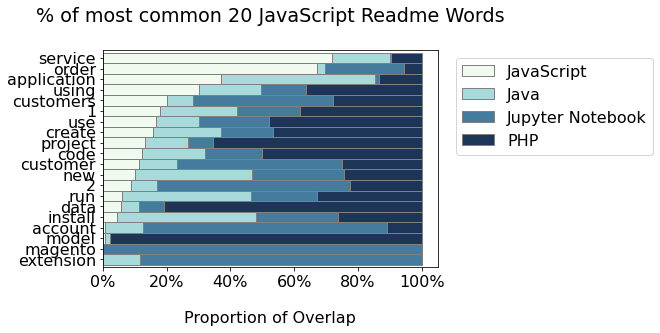

<Figure size 1152x648 with 0 Axes>

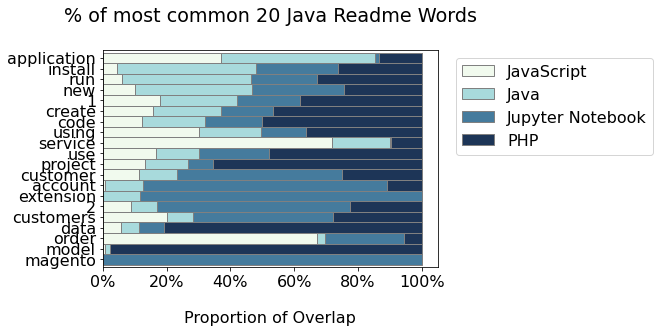

<Figure size 1152x648 with 0 Axes>

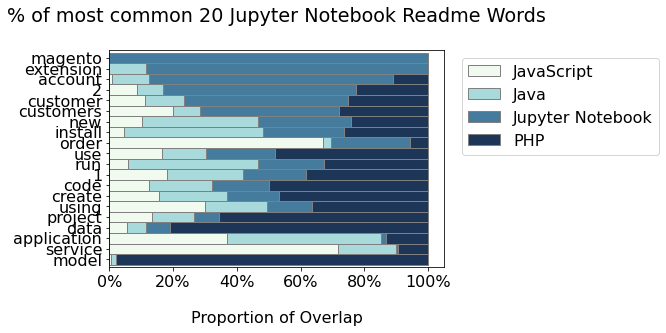

<Figure size 1152x648 with 0 Axes>

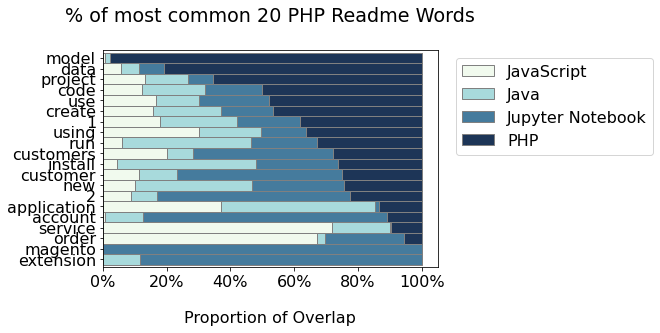

In [32]:
# create stacked bar charts for each of the 4 categories vs. top most common words
for language in languages:
    explore.plot_overlap_stacked_bar(word_counts, language, colors=blues)

In [33]:
#df = pd.read_json('data2.json')
#df = prepare.drop_unneeded_data(df)
#df = prepare.prepare_nlp_data(df, content = 'readme_contents', extra_words=[])

In [34]:
df.shape

(106, 6)

In [35]:
# vectorize and fit the data, then split it
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.clean)
y_data = df.language

# use function from above (need to put in a module)
# split to X/y datasets 

X_train, y_train, X_validate, y_validate, X_test, y_test = model.nlp_X_train_split(X_data, y_data)

In [53]:
train.shape, validate.shape, test.shape

((58, 2), (26, 2), (22, 2))

In [37]:
df.language.value_counts()

PHP                 40
Jupyter Notebook    30
JavaScript          21
Java                15
Name: language, dtype: int64

In [38]:
#PHP is the baseline prediction
print(f'Baseline Accuracy: {round(max(df.language.value_counts()) / df.shape[0] *100)}%')

Baseline Accuracy: 38%


**Logistic Regression**

In [39]:
#Using the vectorized data, make a logistic regression model
lm = LogisticRegression()

#Fit the lm object to the vectorized data
lm.fit(X_train, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the lm model
train['predicted'] = lm.predict(X_train)
validate["predicted"] = lm.predict(X_validate)
test['predicted'] = lm.predict(X_test)

#Review how the lm model performed on the in-sample data
print('In-sample data model performance:')
print(classification_report(train.actual, train.predicted, zero_division=0))
print('----------------')
#Review how the lm model performed on the out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(validate.actual, validate.predicted, zero_division=0))


In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.75      0.86         8
      JavaScript       1.00      0.91      0.95        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       0.88      1.00      0.94        22

        accuracy                           0.95        58
       macro avg       0.97      0.91      0.94        58
    weighted avg       0.95      0.95      0.95        58

----------------
Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         4
      JavaScript       1.00      0.20      0.33         5
Jupyter Notebook       0.88      1.00      0.93         7
             PHP       0.62      1.00      0.77        10

        accuracy                           0.73        26
       macro avg       0.88      0.61      0.61        26
    weighted avg       0.82      0.7

**KNN Model**

In [40]:
#Create the KNN object with a k = 10
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

#Fit the object to the vectorized training data
knn.fit(X_train, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the knn model
train['predicted'] = knn.predict(X_train)
validate["predicted"] = knn.predict(X_validate)

#Review how the knn model performed on the in-sample data
print('In-sample data model performance:')
print(classification_report(train.actual, train.predicted,  zero_division=0))
print('----------------')
#Review how the knn model performed on the out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(validate.actual, validate.predicted, zero_division=0))

In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58

----------------
Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       0.67      0.50      0.57         4
      JavaScript       1.00      0.40      0.57         5
Jupyter Notebook       0.78      1.00      0.88         7
             PHP       0.83      1.00      0.91        10

        accuracy                           0.81        26
       macro avg       0.82      0.72      0.73        26
    weighted avg       0.82      0.8

**Random Forest Model**

In [41]:
#Create the RF object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

#Fit the RF object to the training data
rf.fit(X_train, y_train)

#Predict on y
y_pred = rf.predict(X_train)

#Evaluate
print('In-sample data model performance:')
print(classification_report(y_train, y_pred))

#Predict using out of sample data
y_pred = rf.predict(X_validate)
print('----------------')
print('Out-of-sample data model performance:')
print(classification_report(y_validate, y_pred, zero_division=0))

In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.88      0.93         8
      JavaScript       1.00      0.91      0.95        11
Jupyter Notebook       1.00      0.88      0.94        17
             PHP       0.85      1.00      0.92        22

        accuracy                           0.93        58
       macro avg       0.96      0.92      0.93        58
    weighted avg       0.94      0.93      0.93        58

----------------
Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         4
      JavaScript       1.00      0.60      0.75         5
Jupyter Notebook       0.88      1.00      0.93         7
             PHP       0.71      1.00      0.83        10

        accuracy                           0.81        26
       macro avg       0.90      0.71      0.73        26
    weighted avg       0.86      0.8

**Decision Tree Modeling**

In [42]:
#Make the CLF object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=123)

#Fit the model on the training set 
clf = clf.fit(X_train, y_train)

#Make predictions
y_pred = clf.predict(X_train)

#Evaluate model performance on training data
print('In-sample data model performance:')
print(classification_report(y_train, y_pred))

# Predict on validate
y_pred = clf.predict(X_validate)

# Evaluate model performance on out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(y_validate, y_pred, zero_division=0))


In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58

Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       0.50      0.25      0.33         4
      JavaScript       1.00      1.00      1.00         5
Jupyter Notebook       0.64      1.00      0.78         7
             PHP       1.00      0.80      0.89        10

        accuracy                           0.81        26
       macro avg       0.78      0.76      0.75        26
    weighted avg       0.83      0.81      0.79      

**Takeaways:**
- The best performing models from the 4 above are Decision Tree, Random Forest and KNN with 81% accuracy.
- They all outperformed Logistic Regression which had 73% accuracy.

In [43]:
train.head()

,actual,predicted
23,Java,Java
6,Java,Java
26,Java,Java
45,PHP,PHP
70,Jupyter Notebook,Jupyter Notebook


In [44]:
train.shape

(58, 2)

**KNN on test data**

In [46]:
test['predicted'] = knn.predict(X_test)
print('Out-of-sample data model performance:')
print(classification_report(test.actual, test.predicted, zero_division=0))

Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       0.50      1.00      0.67         3
      JavaScript       1.00      0.20      0.33         5
Jupyter Notebook       1.00      1.00      1.00         6
             PHP       0.89      1.00      0.94         8

        accuracy                           0.82        22
       macro avg       0.85      0.80      0.74        22
    weighted avg       0.89      0.82      0.78        22



**Takeaways**
- The KNN Model improves upon the baseline accuracy by 44 percentage points
- This model can be further improved by gathering more data